u1up0ng 20201111

# Sparkify Project Workspace - Medium Dataset
This workspace contains a tiny subset **(256MB)** of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# this was originally created inside udacity workspace
# BUT was ported to local machine toward the end since Udacity's workspace keeps tming out.

# to be deleted if not needed

import findspark
findspark.init()

In [2]:
# import libraries

from pyspark.sql import SparkSession

# pyspark sql functions
from pyspark.sql.functions import countDistinct, udf, to_date, count, col, isnan, when
from pyspark.sql.functions import sum, mean, avg, approx_count_distinct
from pyspark.sql.functions import min, max, lit, round, substring, create_map, substring_index

#pyspark types
from pyspark.sql.types import StructType, IntegerType, StringType, FloatType, StructField

#pyspark window
from pyspark.sql.window import Window

#pyspark ml
from pyspark.ml.feature import VectorAssembler, StandardScaler,StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# other python modules
import pandas as pd
import numpy as np
from itertools import chain

# sklearn metrics
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime as dt

import warnings
warnings.filterwarnings('ignore')

In [3]:
# create a Spark session
spark = (SparkSession
         .builder
         .appName('Sparkify_u1up0ng')
         .getOrCreate())

In [4]:
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `medium-sparkify-event-data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
# read json file
#df = spark.read.json('mini_sparkify_event_data.json')
df = spark.read.json('medium-sparkify-event-data.json')
df.show(3)

+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
|           artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|              song|status|           ts|           userAgent|userId|
+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
|    Martin Orford|Logged In|   Joseph|     M|           20| Morales|597.55057| free|  Corpus Christi, TX|   PUT|NextSong|1532063507000|      292|     Grand Designs|   200|1538352011000|"Mozilla/5.0 (Mac...|   293|
|John Brown's Body|Logged In|   Sawyer|     M|           74|  Larson|380.21179| free|Houston-The Woodl...|   PUT|NextSong|1538069638000|    

In [6]:
# describe data
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# count of rows
print(f' Data have {df.count()} rows')

 Data have 543705 rows


In [8]:
# check level and auth columns; to focus on data of interest
df.select(['level', 'auth']).dropDuplicates().orderBy(['level', 'auth']).show()

+-----+----------+
|level|      auth|
+-----+----------+
| free| Cancelled|
| free|     Guest|
| free| Logged In|
| free|Logged Out|
| paid| Cancelled|
| paid| Logged In|
| paid|Logged Out|
+-----+----------+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

## Create Dataframe of interest (paying customers and in session)

In [9]:
# create dataframe 
df_paying = df.where('level == "paid" and auth != "Logged Out"')
df_paying.show(3)

+----------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
|    artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|              song|status|           ts|           userAgent|userId|
+----------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
|   Afroman|Logged In| Maverick|     M|          184|Santiago|202.37016| paid|Orlando-Kissimmee...|   PUT|NextSong|1535953455000|      178|Because I Got High|   200|1538352118000|"Mozilla/5.0 (Mac...|   179|
|      null|Logged In| Maverick|     M|          185|Santiago|     null| paid|Orlando-Kissimmee...|   PUT|  Logout|1535953455000|      178|              null|   307|153

### Explore Data

In [10]:
# count of rows
print(f'Paying data have {df_paying.count()} rows')

Paying data have 418044 rows


In [11]:
# verify there are no guest nor null userIds, as they are not data of interest

df_paying.where('auth = "Guest" or userId = ""').show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [12]:
# function to check for nulls

# CODE WAS LARGELY TAKEN FROM REFERENCE # 2

def null_check(df):
    
    print(f'Count of Nulls in {df} dataframe')
    (df
     .select([count(when(isnan(i)
                         | col(i).contains('NA')
                         | col(i).contains('NULL')
                         |col(i).isNull(), i))
              .alias(i) for i in df.columns])
     .show())

In [13]:
null_check(df_paying)

Count of Nulls in DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string] dataframe
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 68430|   0|        0|     0|            0|       0| 68262|    0|       0|     0|   0|           0|        0|68330|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+----

In [14]:
# check some dimension values f the columns; also check for nulls

cols_to_check = ['auth', 'gender', 'level', 'method', 'page', 'status', ['page', 'method']]

for i in cols_to_check:
    print(f'Values found in "{i}" column')
    cols_count = df_paying.select(i).dropDuplicates().count()
    df_paying.groupBy(i).count().orderBy('count', ascending=False).show(cols_count)

Values found in "auth" column
+---------+------+
|     auth| count|
+---------+------+
|Logged In|417977|
|Cancelled|    67|
+---------+------+

Values found in "gender" column
+------+------+
|gender| count|
+------+------+
|     M|239349|
|     F|178695|
+------+------+

Values found in "level" column
+-----+------+
|level| count|
+-----+------+
| paid|418044|
+-----+------+

Values found in "method" column
+------+------+
|method| count|
+------+------+
|   PUT|394234|
|   GET| 23810|
+------+------+

Values found in "page" column
+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|349782|
|           Thumbs Up| 19504|
|                Home| 13956|
|     Add to Playlist| 10033|
|          Add Friend|  6341|
|              Logout|  4184|
|           Downgrade|  3811|
|         Thumbs Down|  3771|
|            Settings|  2240|
|                Help|  2076|
|               About|   827|
|         Roll Advert|   436|
|       Sa

In [15]:
# quantify discreet dimensions on some of the columns

cols_to_check = ['artist', 'firstName', 'lastName', 'location', 'sessionId', 'song', 'userAgent', 'userId']

for i in cols_to_check:
    print(f'Unique Counts for "{i}" column')
    df_paying.select(countDistinct(i)).show()

Unique Counts for "artist" column
+----------------------+
|count(DISTINCT artist)|
+----------------------+
|                 20054|
+----------------------+

Unique Counts for "firstName" column
+-------------------------+
|count(DISTINCT firstName)|
+-------------------------+
|                      258|
+-------------------------+

Unique Counts for "lastName" column
+------------------------+
|count(DISTINCT lastName)|
+------------------------+
|                     212|
+------------------------+

Unique Counts for "location" column
+------------------------+
|count(DISTINCT location)|
+------------------------+
|                     161|
+------------------------+

Unique Counts for "sessionId" column
+-------------------------+
|count(DISTINCT sessionId)|
+-------------------------+
|                     3145|
+-------------------------+

Unique Counts for "song" column
+--------------------+
|count(DISTINCT song)|
+--------------------+
|               72541|
+---------------

In [16]:
# investigate rows with artist is null
df_paying.where('isNull(artist)').show(3)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|     page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In| Maverick|     M|          185|Santiago|  null| paid|Orlando-Kissimmee...|   PUT|   Logout|1535953455000|      178|null|   307|1538352119000|"Mozilla/5.0 (Mac...|   179|
|  null|Logged In| Maverick|     M|          190|Santiago|  null| paid|Orlando-Kissimmee...|   GET|     Home|1535953455000|      178|null|   200|1538352176000|"Mozilla/5.0 (Mac...|   179|
|  null|Logged In|    Sofia|     F|          268|  Gordon|  

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [17]:
# Create Churn column

# create labeler function
churn_labeler = udf(lambda ischurn: int(ischurn == 'Cancelled'), IntegerType())

# create label column
df_paying = df_paying.withColumn('Churn', churn_labeler(col('auth')))
df_paying.show(3)

+----------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+-----+
|    artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|              song|status|           ts|           userAgent|userId|Churn|
+----------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+-----+
|   Afroman|Logged In| Maverick|     M|          184|Santiago|202.37016| paid|Orlando-Kissimmee...|   PUT|NextSong|1535953455000|      178|Because I Got High|   200|1538352118000|"Mozilla/5.0 (Mac...|   179|    0|
|      null|Logged In| Maverick|     M|          185|Santiago|     null| paid|Orlando-Kissimmee...|   PUT|  Logout|1535953455000|      178|     

In [18]:
# create dates for possible use later

# create function
get_date = udf(lambda x: dt.fromtimestamp(x / 1000.0).strftime('%Y/%m/%d') )

# create date column
df_paying = df_paying.withColumn('date', to_date(get_date(df_paying.ts),'yyyy/mm/dd'))

#create registrationDate
df_paying = df_paying.withColumn('registrationDate', to_date(get_date(df_paying.registration),'yyyy/mm/dd'))

df_paying.show(3)

+----------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+-----+----------+----------------+
|    artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|              song|status|           ts|           userAgent|userId|Churn|      date|registrationDate|
+----------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+-----+----------+----------------+
|   Afroman|Logged In| Maverick|     M|          184|Santiago|202.37016| paid|Orlando-Kissimmee...|   PUT|NextSong|1535953455000|      178|Because I Got High|   200|1538352118000|"Mozilla/5.0 (Mac...|   179|    0|2018-01-30|      2018-01-02|
|      null|Logged In| Maverick|

#### Explore Churn Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [19]:
# number of users
number_of_users = df_paying.select("userId").dropDuplicates().count()

# list of churned userId
churned_userId = df_paying.where('Churn == 1').select('userId').dropDuplicates().collect()
churned_userId_list = [row.userId for row in churned_userId]

In [20]:
# function to identify and separate churned and current userIds 
# preffered isin than join, due to familiarity

def is_churn(churn_label):
    """
    function to identify and separate churned and current userIds 
    
    input: use churn values, churned users = 1
    """
    
    if churn_label == 1:
        data = df_paying.where(col('userId').isin(churned_userId_list))
    else:
        data = df_paying.where(~col('userId').isin(churned_userId_list))
        
    return data

In [21]:
# charting functions; code from REFERENCE # 6
def labeler():
    for p in ax.patches:
        ax.annotate(np.round(p.get_height(),decimals=3)
                    ,(p.get_x()+p.get_width()/2., p.get_height())
                    ,ha='center'
                    ,va='center'
                    ,xytext=(0, 10)
                    ,textcoords='offset points')

In [22]:
# User distribution
number_of_users
print(f'Number of unique users: {number_of_users} \n')
print(f'Number of Churned Users: {len(churned_userId_list)}')  
print(f'Number of Current Users: {number_of_users - len(churned_userId_list)}')  

Number of unique users: 321 

Number of Churned Users: 67
Number of Current Users: 254


<br>**Question:** Do churning customers hold shorter subscription duration?
> Plot below shows that churning customers slightly held longer subscription period to some degree

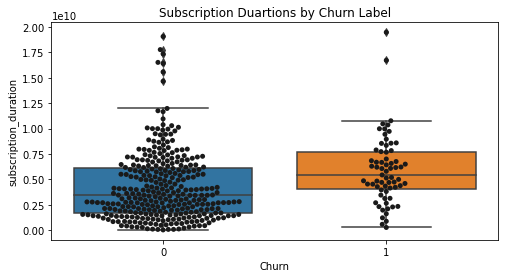

In [23]:
# create data for subscription duration
data = (df_paying
        .orderBy(['userId', 'Churn'])
        .dropDuplicates(['userId', 'Churn'])
        .select('userId', 'Churn', 'ts', 'registration')
        .withColumn('period', col('ts')-col('registration'))
        .groupby(['userId', 'Churn'])
        .max('period')
        .withColumnRenamed('max(period)','subscription_duration')
        .toPandas())

# boxplot of subscription period per Churn label
plt.figure(figsize=(8, 4))
ax = sns.swarmplot(data=data, x='Churn', y='subscription_duration', color='.1')
ax = sns.boxplot(data=data, x='Churn', y='subscription_duration')
ax.set_title('Subscription Durations by Churn Label');

**Percentage of action pages: ThumbsUp, ThumbsDown, FriendAdd, Add to Playlist, Downgrade, and Roll Advert**

> Table comparisons below show noticeable percent differences in some of the action pages

In [24]:
# function for percentage of action pages

# list of page values
action_pages = ['Thumbs Up', 'Thumbs Down', 'Add Friend'
                , 'Add to Playlist', 'Downgrade'
                , 'Submit Downgrade', 'Roll Advert', 'NextSong']

def analyze_action_pages(churn_label):
    """
    function to identify churned userIds 
    
    input: use churn values, churned users = 1
    """
    schema = StructType([StructField('avgPageCount', FloatType(), True)
                         , StructField('churn', IntegerType(), False)
                         , StructField('pageLabel', StringType(), False)])
    data = spark.createDataFrame([], schema)
                         
    for n in churn_label:
        for i in action_pages:             
            page_value_count =(is_churn(n)
                               .where(col('page') == i)
                               .groupBy(['userId', 'page'])
                               .count()
                               .drop('page'))

            data = data.union(is_churn(n)
                              .groupBy('userId')
                              .agg(count('userId'))
                              .join(page_value_count, 'userId')
                              .withColumn(i, col('count') / col('count(userId)') * 100)
                              .drop('count(userId)', 'count', 'userId')
                              .agg(avg(col(i)))
                              .withColumn('churn', lit(n))
                              .withColumn('pageLabel', lit(i)))
            
            
    return data

In [25]:
# analyze percentage of action pages on churned users
df_action_pages = analyze_action_pages([1, 0])
df_action_pages.orderBy('pageLabel', 'churn').show()

+-------------------+-----+----------------+
|       avgPageCount|churn|       pageLabel|
+-------------------+-----+----------------+
| 1.7076727231449478|    0|      Add Friend|
|  1.520446255370031|    1|      Add Friend|
|  2.439446321973338|    0| Add to Playlist|
| 2.3013523368181583|    1| Add to Playlist|
| 1.0399917709079027|    0|       Downgrade|
| 1.3588226292796786|    1|       Downgrade|
|  83.24792369921195|    0|        NextSong|
|  82.70814493921021|    1|        NextSong|
|0.20204158527444233|    0|     Roll Advert|
|0.45053497286918104|    1|     Roll Advert|
| 0.2573693668967059|    0|Submit Downgrade|
|0.14033382031644345|    1|Submit Downgrade|
| 0.9994881366082411|    0|     Thumbs Down|
| 1.1512654358866283|    1|     Thumbs Down|
|  4.695474986217572|    0|       Thumbs Up|
|  4.130778192105568|    1|       Thumbs Up|
+-------------------+-----+----------------+



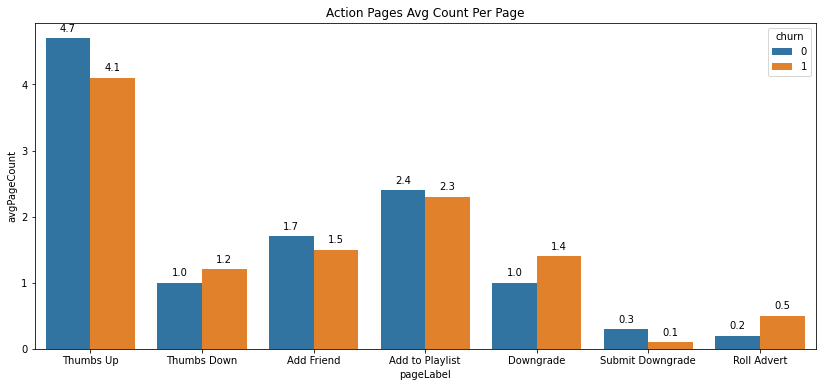

In [26]:
# create bar graph for Action page; exclude NextSong for better insight

data  = df_action_pages.where('pageLabel != "NextSong"').toPandas()
data['avgPageCount'] = data['avgPageCount'].round(decimals=1)

# barplot of Action Pages
plt.figure(figsize=(14, 6))
ax = sns.barplot(x='pageLabel', y='avgPageCount', hue='churn', data=data)
labeler()
ax.set_title('Action Pages Avg Count Per Page');

<br> **Question:** Do churners songs per user per day count behave differently than current users?
> plot below shows more stable song per user on current subscribers compared churned subscriber

In [27]:
# Songs per user comparison
window = Window.partitionBy('date', 'userid').orderBy('date')

data = pd.DataFrame() 

for i in [1, 0]:
    if i==1:
        #print('Churned Customers daily song count per user')
        label = 'Churned'
    else:
        label = 'Current'
        
    data = data.append(is_churn(i)
                       .withColumn('userCnt', approx_count_distinct('userId').over(window))
                       .withColumn('songCnt', count('song').over(window))
                       .select('userid', 'date', 'songCnt', 'userCnt')
                       .groupBy('date')
                       .agg(sum('songCnt')/sum('userCnt'))
                       .withColumnRenamed('(sum(songCnt) / sum(userCnt))','aveSongperUser')
                       .withColumn('churn', lit(i))
                       .orderBy('date', 'churn')
                       .toPandas())

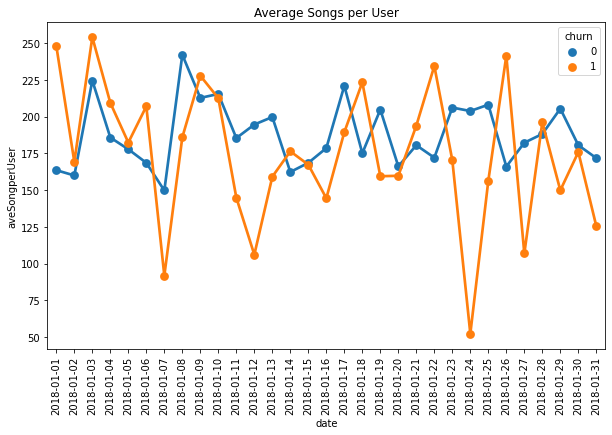

In [28]:
# barplot of Action Pages
plt.figure(figsize=(10, 6))
ax = sns.pointplot(x='date', y='aveSongperUser', hue='churn', data=data)
ax.set_title('Average Songs per User')
plt.xticks(rotation=90);

<br> **Question:**  Do churning customer slowly reduce their number interaction before cancelling?
> plot below shows churners have inconsistent interaction behaviour before cancelling

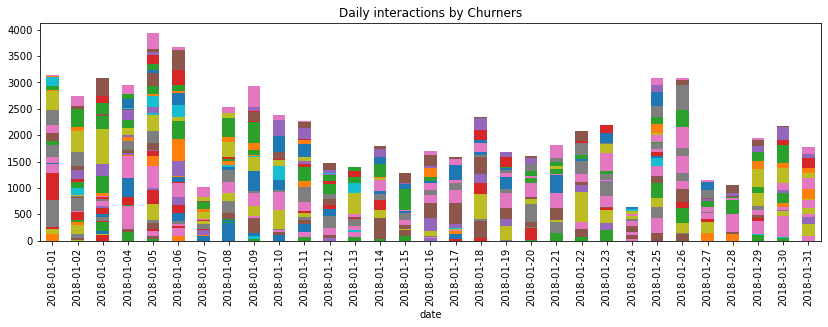

In [29]:
data = (df_paying.where(col('userId').isin(churned_userId_list))
        .select('userId', 'date', 'page')
        .groupBy('userId', 'date')
        .agg(count('page'))
        .withColumnRenamed('count(page)','interactions')
        .orderBy('userId','date')
        .toPandas())

# stacked bar graph to visualize interaction of churners
(data.groupby(['date', 'userId'])
 .mean()
 .unstack()['interactions']
 .plot(kind='bar', stacked=True, figsize=(14,4), title='Daily interactions by Churners')
 .get_legend()
 .remove())

``` python
#same as above, but in line graph per user for better intuition (not shown on final report)
for i in list(data.userId.unique()):
    (data
     .query('userId == @i')[['date', 'interactions']]
     .set_index('date')
     .plot(figsize=(14,0.5), title='Interactions for userId '+i)
     .get_legend()
     .remove())
```

<br> **Question:** Do churners play lesser songs per day before cancelling?
> plot shows churners have inconsistent behaviour on playing songs before cancelling

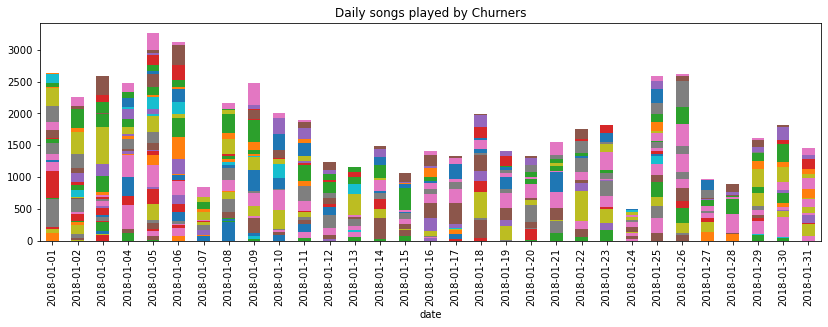

In [30]:
data = (df_paying.where(col('userId').isin(churned_userId_list))
        .select('userId', 'date', 'song')
        .groupBy('userId', 'date')
        .agg(count('song'))
        .withColumnRenamed('count(song)','songs_per_day')
        .orderBy('userId','date')
        .toPandas())

# stacked bar graph to visualize interaction of churners
(data
 .groupby(['date', 'userId'])
 .mean()
 .unstack()['songs_per_day']
 .plot(kind='bar', stacked=True, figsize=(14,4), title='Daily songs played by Churners')
 .get_legend()
 .remove())

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### Create dataframe that will be used for modelling

    1) select basic features from df_paying dataframes to be used for model dataframe

In [31]:
# select basic features from df_paying dataframes to be used as model dataframe
df_model = (df_paying
            .groupBy('userId', 'date', substring(df_paying.location, -2, 2).alias('state'))
            .agg(min('ts').alias('sessionDate')
                 , min('registration').alias('registrationDate')
                 , count('sessionId').alias('sessionCount')
                 , count('song').alias('songsCount')
                 , countDistinct('song').alias('uniqueSongCount')
                 , countDistinct('artist').alias('uniqueArtistCount')
                 , (max('ts')-min('registration')).alias('subscriptionDuration')
                 , (max('ts') - min('ts')).alias('sessionDuration'))
           )

In [32]:
# create page action features

for i in action_pages:
    action_page_count = (df_paying.where(col('page') == i)
                         .groupBy(['userId', 'date', 'page'])
                         .count()
                         .withColumnRenamed('count', (i + 'Count').replace(' ', ''))
                         .drop('page'))
    
    df_model = df_model.join(action_page_count, ['userId', 'date'], 'left').na.fill(0)

df_model = df_model.drop('date')

In [33]:
# create label

tag = df_paying.groupby('userId').agg(sum('Churn').alias('label'))
df_model = df_model.join(tag, 'userId', 'left')

In [34]:
df_model.printSchema()

root
 |-- userId: string (nullable = true)
 |-- state: string (nullable = true)
 |-- sessionDate: long (nullable = true)
 |-- registrationDate: long (nullable = true)
 |-- sessionCount: long (nullable = false)
 |-- songsCount: long (nullable = false)
 |-- uniqueSongCount: long (nullable = false)
 |-- uniqueArtistCount: long (nullable = false)
 |-- subscriptionDuration: long (nullable = true)
 |-- sessionDuration: long (nullable = true)
 |-- ThumbsUpCount: long (nullable = true)
 |-- ThumbsDownCount: long (nullable = true)
 |-- AddFriendCount: long (nullable = true)
 |-- AddtoPlaylistCount: long (nullable = true)
 |-- DowngradeCount: long (nullable = true)
 |-- SubmitDowngradeCount: long (nullable = true)
 |-- RollAdvertCount: long (nullable = true)
 |-- NextSongCount: long (nullable = true)
 |-- label: long (nullable = true)



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

> Create Data Transformation Pipeline

In [35]:
# This function is mostly taken from REFERENCE #3

def data_pipeline(data):
    """
    Function to pipeline to transform data for model creation 
    """
    # define stage 1: transform the dimension feature to numeric
    stage_1 = StringIndexer(inputCol='state', outputCol='stateIdx')

    # define stage 2: create a vector of all the features required to train model
    inputCols = data.columns[2:-1]+['stateIdx']
    stage_2 = VectorAssembler(inputCols=inputCols,outputCol='features')

    # define stage 3: scale data
    stage_3 = StandardScaler(inputCol='features', outputCol='scaledFeatures')

    # setup the pipeline
    pipeline = Pipeline(stages=[stage_1, stage_2, stage_3])
               
    # fit the pipeline for the training data
    model = pipeline.fit(data)
               
    # transform the data
    data = model.transform(data)   

    return data

In [36]:
# finalize model dataframe
df_model = data_pipeline(df_model)

In [37]:
df_model.printSchema()

root
 |-- userId: string (nullable = true)
 |-- state: string (nullable = true)
 |-- sessionDate: long (nullable = true)
 |-- registrationDate: long (nullable = true)
 |-- sessionCount: long (nullable = false)
 |-- songsCount: long (nullable = false)
 |-- uniqueSongCount: long (nullable = false)
 |-- uniqueArtistCount: long (nullable = false)
 |-- subscriptionDuration: long (nullable = true)
 |-- sessionDuration: long (nullable = true)
 |-- ThumbsUpCount: long (nullable = true)
 |-- ThumbsDownCount: long (nullable = true)
 |-- AddFriendCount: long (nullable = true)
 |-- AddtoPlaylistCount: long (nullable = true)
 |-- DowngradeCount: long (nullable = true)
 |-- SubmitDowngradeCount: long (nullable = true)
 |-- RollAdvertCount: long (nullable = true)
 |-- NextSongCount: long (nullable = true)
 |-- label: long (nullable = true)
 |-- stateIdx: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- scaledFeatures: vector (nullable = true)



In [38]:
# clear memory
df.unpersist()
df_paying.unpersist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, Churn: int, date: date, registrationDate: date]

> Split Train and Test Dataset

In [39]:
# Create function to split data into train and test datasets

def train_test_split(data = df_model.drop('features'), test_size=0.2):
    """
    Split data into train and test datasets
    
    input: model datat and test size
    
    output: train and split data
    """
    return data.randomSplit([1-test_size, test_size], seed=42)

train, test = train_test_split()
#print(f' Count of training data: {train.count()} rows')
#print(f' Count of test data: {test.count()} rows')

> Initiate Classifiers

In [40]:
# baseline classifiers
lr = LogisticRegression(featuresCol='scaledFeatures', labelCol='label')
rf = RandomForestClassifier(featuresCol='scaledFeatures', labelCol='label')
gb = GBTClassifier(featuresCol='scaledFeatures', labelCol='label')

In [41]:
# Function to evaluate model
def evaluate_model(model, train=train, test=test):
    """
    Function to evaluate model
    input: model, train, test
    output: f1_score, auroc_score, y_true, y_pred, importance_score
    """
    fitModel = model.fit(train)
    fitModelResult = fitModel.transform(test)
    
    f1_score = (MulticlassClassificationEvaluator(metricName='f1')
                .evaluate(fitModelResult.select(col('label'), col('prediction'))))
    
    auroc_score = (BinaryClassificationEvaluator(metricName='areaUnderROC')
                 .evaluate(fitModelResult))
    
    y_true = np.array(fitModelResult.select(['label']).collect())
    y_pred = np.array(fitModelResult.select(['prediction']).collect())
 
    return f1_score, auroc_score, y_true, y_pred, fitModel

In [42]:
# fundtion to display model metrics
def print_metrics(model = [gb, rf, lr]):
    """
    Function to display model metrics and Feature Imporance
    input: models, importance_score (0: dont print; 1: print), data
    output : metric printouts
    """

    for clf in model:
        if clf == lr:
            tagclf = 'LogisticRegression Classifier'
        elif clf == rf:
            tagclf = 'RandomForest Classifier'
        else:
            tagclf = 'Gradient-Boosted Trees Calssifier'

        f1_score, auroc_score, y_true, y_pred, fitModel = evaluate_model(clf)

        #print results and score
        print(f'\n \n{tagclf}: \n f1_score = {f1_score} \n AUROC score = {auroc_score} \n')
        print('Classification Report \n', classification_report(y_true, y_pred))
        print('Confusion Matrix \n', confusion_matrix(y_true, y_pred))
        
    return fitModel

In [43]:
# Show Metrics of Baseline Models
print('Baseline Models:')
print_metrics()

Baseline Models:

 
Gradient-Boosted Trees Calssifier: 
 f1_score = 0.8314450625180155 
 AUROC score = 0.8310223109231174 

Classification Report 
               precision    recall  f1-score   support

           0       0.87      0.98      0.92       569
           1       0.73      0.28      0.40       118

    accuracy                           0.86       687
   macro avg       0.80      0.63      0.66       687
weighted avg       0.84      0.86      0.83       687

Confusion Matrix 
 [[557  12]
 [ 85  33]]

 
RandomForest Classifier: 
 f1_score = 0.7565792439190369 
 AUROC score = 0.7588543683536383 

Classification Report 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91       569
           1       0.67      0.02      0.03       118

    accuracy                           0.83       687
   macro avg       0.75      0.51      0.47       687
weighted avg       0.80      0.83      0.76       687

Confusion Matrix 
 [[568   1]
 [116

LogisticRegressionModel: uid = LogisticRegression_c2eb5a52f673, numClasses = 2, numFeatures = 17

**Best Result: Gradient-Boosted Trees**
> Will tune the model with the ParamGridBuilder and the CrossValidator; below is the hyperparametr strategy

In [44]:
# print list of parameters
print(gb.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

```python
# COMMENTED OUT since it would take time to run ..

# Create cross validation to improve Gradient-Boosted Trees Calssifier model
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

paramGrid = (ParamGridBuilder()
             .addGrid(gb.stepSize, [0.05, 0.1, 0.15])
             .addGrid(gb.maxDepth, [4,5,6])
             .addGrid(gb.maxBins, [20, 32, 60])
             .addGrid(gb.maxIter, [20, 50, 100])
             .build())

cv = CrossValidator(estimator=gb, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations
print_metrics([cv])
```

**Refinement**
> Further Optimization of Model is possible. However due to lack of time; and machines that keeps crashing (Udacity and user machine; I settled on the model below. 

In [45]:
gb_opt = GBTClassifier(featuresCol='scaledFeatures'
                       , labelCol='label'
                       , maxIter = 100
                       , stepSize=.05
                       , maxDepth = 6
                       , maxBins = 60
                      )

print('Optimized Model:')
model_opt = print_metrics([gb_opt])

Optimized Model:

 
Gradient-Boosted Trees Calssifier: 
 f1_score = 0.8865567129876657 
 AUROC score = 0.8933752345774618 

Classification Report 
               precision    recall  f1-score   support

           0       0.90      0.98      0.94       569
           1       0.85      0.49      0.62       118

    accuracy                           0.90       687
   macro avg       0.88      0.74      0.78       687
weighted avg       0.89      0.90      0.89       687

Confusion Matrix 
 [[559  10]
 [ 60  58]]


**Check Feature Importance**


                       Feature_Importance
sessionDate                        0.087
registrationDate                   0.283
sessionCount                       0.042
songsCount                         0.015
uniqueSongCount                    0.013
uniqueArtistCount                  0.017
subscriptionDuration               0.074
sessionDuration                    0.051
ThumbsUpCount                      0.023
ThumbsDownCount                    0.020
AddFriendCount                     0.028
AddtoPlaylistCount                 0.028
DowngradeCount                     0.033
SubmitDowngradeCount               0.002
RollAdvertCount                    0.016
NextSongCount                      0.000
state                              0.267


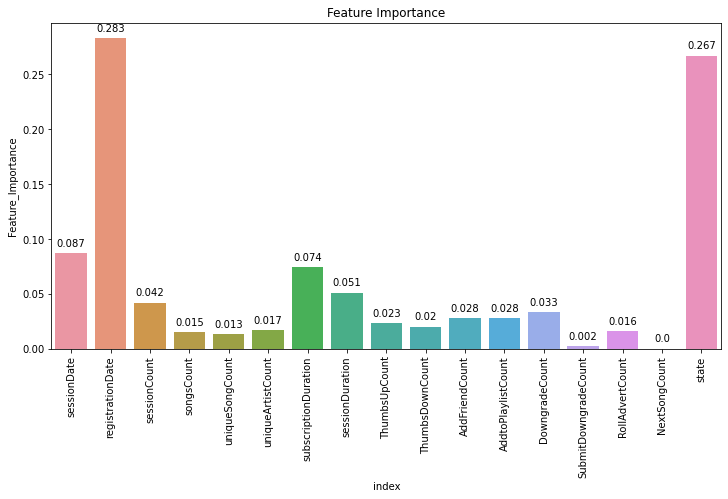

In [46]:
inputCols = df_model.columns[2:-4]+['state']
importance_data = pd.DataFrame(index= inputCols
             , columns = ['Feature_Importance']
             , data = model_opt.featureImportances.toArray().round(decimals=3).T,)

print('\n', importance_data)


# barplot of Feature Importance
plt.figure(figsize=(12, 6))
ax = sns.barplot(y='Feature_Importance'
                 , data=importance_data.reset_index()
                 , x = 'index')
labeler()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Feature Importance');

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

# References
1.  [How to count the null,na and nan values in each column of pyspark dataframe](https://stackoverflow.com/questions/56095451/how-to-count-the-null-na-and-nan-values-in-each-column-of-pyspark-dataframe)
1. [Balancing Model Weights in PySPark](https://danvatterott.com/blog/2019/11/18/balancing-model-weights-in-pyspark/)
1. [Want to Build Machine Learning Pipelines? A Quick Introduction using PySpark](https://www.analyticsvidhya.com/blog/2019/11/build-machine-learning-pipelines-pyspark/)
1. [In Depth: Parameter tuning for Gradient Boosting](https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae)
1. [GBTClassifier
](http://maxpumperla.com/java-book/api/scala/org/apache/spark/ml/classification/GBTClassifier.html)
1. [Annotate bars with values on Pandas bar plots](https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots)

### Appendix
> Saving the code below for use in future optimization; where weights might be needed in Logistic Regression

Create "weights" to handle unbalanced data
(this was not used; since models performed well ...)

```python
# create "weights" to manage unbalanced data
# CODE WAS LARGELY TAKEN FROM REFERENCE # 2

y_collect = df_model.select("label").groupBy("label").count().collect()
unique_y = [x["label"] for x in y_collect]
total_y = df_model.count()
unique_y_count = len(y_collect)
bin_count = [x["count"] for x in y_collect]

class_weights_spark = {i: ii for i, ii in zip(unique_y, total_y / (unique_y_count * np.array(bin_count)))}
print(class_weights_spark)


# assign weight to each instance
mapping_expr = create_map([lit(x) for x in chain(*class_weights_spark.items())])

df_model = df_model.withColumn('weight', mapping_expr.getItem(col('label')))

```


ulup0ng 20201126